In [ ]:
#Author:    Rui Ding
#Created:   04.14.2020

In [64]:
#Import packages
from sympy import *
import pandas as pd
import numpy as np
from scipy.stats import norm,mstats,spearmanr
from scipy import optimize
from scipy.optimize import Bounds
from collections import defaultdict 
from itertools import permutations
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load preprocessed returns and drawdowns data
Ret = np.load('Full_ret.npy')
Drawdown = np.load('Drawdown.npy')

In [3]:
#Load names
names = list(np.load('list_names.npy'))

## Defining Various Copula Structures

### Frank-Archimedean Copula Density Calculation

In [17]:
def FAP(n):
    x = symbols('x')
    if n==1:
        y = 1/x
    else:
        x,z = FAP(n-1)
        y = z+diff(z,x)*(x-1)
    return x,y

In [18]:
def function_FAP(n):
    x,y = FAP(n)
    f = lambdify(x,y, 'numpy')
    return f

In [19]:
def frank_copula_density(u,theta):
    K = len(u)
    A = 1.0/(np.exp(-theta)-1)**(K-1)
    for i in range(K):
        A*=(np.exp(-theta*u[i])-1)
    A+=1
    P = function_FAP(K)
    c = (-theta)**(K-1)*np.exp(-theta*np.sum(u))*P(A)/(np.exp(-theta)-1)**(K-1)
    return c

### Gumbel Copula Density Calculation

In [20]:
def GAP(n,theta):
    x = symbols('x')
    if n==1:
        y = x**(1.0/theta - 1)
    else:
        x,z = GAP(n-1,theta)
        y = x**(1.0/theta - 1)*z-theta*diff(z,x)
    return x,y

In [21]:
def function_GAP(n,theta):
    x,y = GAP(n,theta)
    f = lambdify(x,y, 'numpy')
    return f

In [22]:
def gumbel_copula_density(u,theta):
    K = len(u)
    A = np.sum((-np.log(u))**theta)

    P = function_GAP(K,theta)
    c = P(A)*np.exp(-A**(1.0/theta))
    for i in range(K):
        c*=(-np.log(u[i]))**(theta-1) / u[i]
    return c

### Clayton Copula Density Calculation

In [23]:
def clayton_copula_density(u,theta):
    K = len(u)
    c = (np.sum(np.array(u)**(-theta))+1-K)**(-1.0/theta-K)
    for i in range(K):
        c *= (u[i])**(-theta-1) * (1+theta*i)
    return c

### Uniform Correlation Gaussian Copula Density Calculation

In [24]:
def gaussian_copula_density(u,rho):
    K = len(u)
    sig = np.ones((K,K))*rho
    for i in range(K):
        sig[i][i] = 1
    sig_inv = np.linalg.inv(sig)
    I = np.eye(K)
    v = np.array([[norm.ppf(u_i) for u_i in u]])
    a = np.dot(np.dot(v,sig_inv-I),v.T)
    c = np.exp(-0.5*a)/np.sqrt(np.linalg.det(sig))
    return c[0][0]

### Copula Density Ratio Calculation and Likelihood Evaluation

In [25]:
def copula_ratio(u,p,copula = 'Gaussian'):
    if copula=="Gaussian":
        r_c = gaussian_copula_density(u,p)/gaussian_copula_density(u[1:],p)
    elif copula=="Frank-Archimedean":
        r_c = frank_copula_density(u,p)/frank_copula_density(u[1:],p)
    elif copula == "Gumbel-Archimedean":
        r_c = gumbel_copula_density(u,p)/gumbel_copula_density(u[1:],p)
    elif copula == "Clayton-Archimedean":
        r_c = clayton_copula_density(u,p)/clayton_copula_density(u[1:],p)
    else:
        r_c = 1
    return r_c
def llh_local(p,F,u,c_type):
    #Log-likelihood summed over the dataset for a single local copula group
    M,N = F.shape
    l=0
    for m in range(M):
        r_c = copula_ratio(F[m,u],p,copula=c_type)
        l+=np.log(r_c)
    return l
def likelihood(P,F,f,G,c_type):
    #Full log-likelihood by summing local log-likelihoods and the marginal densities
        M,N = F.shape
        l=0
        for i in range(N):
            l+=np.sum(np.log(f[:,i]))
        for i in range(len(G)):
            u = G[i]
            if len(u)>1:
                l+=llh_local(P[i],F,u,c_type)
            else:
                pass
        return l

## Copula Bayesian Network Class

#### Directed Network Graph Using Networkx

In [26]:
class CBN:  
    def __init__(self, N, G, param_c=0.5, param_f = [1.06,-0.2], c_type = 'Gaussian'):
        self.N = N
        self.construct_directed_graph(G)
        self.num_copula = len(G)
        self.local_copula = c_type
        self.p_0 = param_c
        self.param_c = np.ones(len(G))*param_c
        self.h_const = param_f[0]
        self.h_power = param_f[1]
    def construct_directed_graph(self,G):
        #Construct DiGraph from given dependency list
        self.G = G
        self.K = len(G)
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def update_G(self):
        #Update list G and reset parameters based on updated graph
        self.G = graph_to_list(self.graph)
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
    def update_graph(self):
        #Update graph based on changed dependency list G
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in self.G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def check_acyclic(self):
        flag = nx.is_directed_acyclic_graph(self.graph)
        return flag
    def draw_network(self,names=None):
        if names==None:
            nx.draw(self.graph,with_labels=True)
        else:
            keys = sorted(self.graph.nodes)
            mapping = {}
            for i in range(len(keys)):
                mapping[keys[i]] = names[i]

            H = nx.relabel_nodes(self.graph, mapping)
            nx.draw(H,with_labels=True)
        plt.draw()
        plt.show()
    def marginal_density_estimate(self,D):
        M = len(D)
        N = len(D[0])
        self.N = N
        F = np.zeros((M,N))
        f = np.zeros((M,N))
        for i in range(N):
            x = D[:,i]
            #Winsorized cdf estimate truncation threshold
            delta = 1.0/(4*M**0.25*np.sqrt(np.log(M)*np.pi))
            x_ = mstats.winsorize(x, limits=[delta, delta]).data
            s = np.std(x)
            #Kernel pdf estimate bandwidth
            h = self.h_const*s*M**(self.h_power)
            for j in range(M):
                F[j,i] = np.sum(1.0*(x<=x_[j]))/(M+1)
                f[j,i] = (1.0/(M*h))*np.sum(np.exp(-0.5*(x-D[j,i])**2)/h**2)/np.sqrt(2*np.pi)
        self.D = D
        self.F = F
        self.f = f
        self.M = M
        return F,f 
    def mle(self):
        p_0 = self.p_0
        neg_llh_local = lambda x,F,u,c: -llh_local(x,F,u,c)
        if self.local_copula=='Frank-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.fmin_cg(neg_llh_local, p_0, args=(self.F,u,self.local_copula),full_output = True)
                opt_p = results[0][0]
                self.param_c[i] = opt_p
        elif self.local_copula=='Gumbel-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([1.0],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        elif self.local_copula=='Clayton-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        else:
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[0.99]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        #Update likelihood and BIC score for current network and optimal parameters
        self.likelihood = likelihood(self.param_c,self.F,self.f,self.G,self.local_copula)
        self.BIC = -2*self.likelihood+np.log(self.N)*self.K
        return self.param_c, self.likelihood, self.BIC
    

#### Helper Functions

In [27]:
def scoring(cbn):
    opt_p,l,s = cbn.mle()
    return -s
def graph_to_list(g):
    d = {}
    for e in list(g.edges):
        if e[1] not in d.keys():
            d[e[1]] = [e[0]]
        else:
            d[e[1]].append(e[0])
    G = []
    for key in d.keys():
        l = d[key]
        full = [key]+list(l)
        G.append(full)
    return G

In [28]:
def HCS(D,N,p_0,copula,cur = []):
    #Hill climbing search
    E = list(permutations(range(N), r=2))
    cbn = CBN(N,cur,param_c = p_0, c_type = copula)
    F,f = cbn.marginal_density_estimate(D)
    g_old = cbn.graph
    g_opt = g_old
    score_old = scoring(cbn)
    score_opt = score_old
    start = True
    if not nx.is_directed_acyclic_graph(g_old):
        print('Input graph is cyclic.')
        return g_old,cur
    while score_opt>score_old or start:
        start=False
        score_old = score_opt
        g_old = g_opt
        for e in E:
            A = []
            if e in g_old.edges:
                A = ['revert','delete']
            elif e[::-1] in g_old.edges:
                pass
            else:
                A = ['add']
            for a in A:
                g = g_old.copy()
                if a=='delete':
                    g.remove_edge(e[0],e[1])
                elif a=='revert':
                    g.remove_edge(e[0],e[1])
                    g.add_edge(e[1],e[0])
                else:
                    g.add_edge(e[0],e[1])
                cbn.graph = g
                cbn.update_G()
                if cbn.check_acyclic():
                    score = scoring(cbn)
                    if score>score_opt:
                        g_opt = g
                        score_opt = score
                    else:
                        pass
                else:
                    continue
    cbn.graph = g_opt
    cbn.update_G()
    opt_p,l,s = cbn.mle()
    print('Optimal likelihood: '+str(l))
    print('Optimal BIC: '+str(s))
    return cbn 

In [104]:
def SPS(D,N,p_0,copula,nbhd = 2, cur = []):
    #Spearman's rho proxy search
    cbn = CBN(N,cur,param_c = p_0, c_type = copula)
    F,f = cbn.marginal_density_estimate(D)
    S_R = spearmanr(F,axis=0)[0]
    E = []
    for i in range(N):
        r = S_R[i]
        top = r.argsort()[-nbhd-1:][::-1]
        for j in range(nbhd):
            E.append((i,top[j+1]))
            E.append((top[j+1],i))
    E = set(E)
    print(E)
    for e in E:
        if e in cbn.graph.edges or e[::-1] in cbn.graph.edges:
            pass
        else:
            cbn.graph.add_edge(e[0],e[1])
    cbn.update_G()
    g_old = cbn.graph
    g_opt = g_old
    score_old = scoring(cbn)
    score_opt = score_old
    start = True
    if not nx.is_directed_acyclic_graph(g_old):
        print('Input graph is cyclic.')
        return g_old,cur
    while score_opt>score_old or start:
        start=False
        score_old = score_opt
        g_old = g_opt
        for e in E:
            A = []
            if e in g_old.edges:
                A = ['revert','delete']
            elif e[::-1] in g_old.edges:
                pass
            else:
                A = ['add']
            for a in A:
                g = g_old.copy()
                if a=='delete':
                    g.remove_edge(e[0],e[1])
                elif a=='revert':
                    g.remove_edge(e[0],e[1])
                    g.add_edge(e[1],e[0])
                else:
                    g.add_edge(e[0],e[1])
                cbn.graph = g
                cbn.update_G()
                if cbn.check_acyclic():
                    print(cbn.graph.edges)
                    score = scoring(cbn)
                    if score>score_opt:
                        g_opt = g
                        score_opt = score
                    else:
                        pass
                else:
                    continue
    cbn.graph = g_opt
    cbn.update_G()
    opt_p,l,s = cbn.mle()
    print('Optimal likelihood: '+str(l))
    print('Optimal BIC: '+str(s))
    return cbn 

## Tests

In [99]:
#Data input
N = 10
M = 250
R = Ret[-M:,:N]
D = Drawdown[-M:,:N]
label = names[:N]

In [100]:
copula = 'Clayton-Archimedean'
p_0 = 1.0

### Performing Proxy Guided Search for Optimal Structure using Returns data

In [101]:
cbn_opt = SPS(R,N,p_0,copula,nbhd=1,cur = [])

{(0, 1), (9, 0), (6, 7), (3, 0), (7, 6), (8, 0), (4, 0), (2, 0), (0, 5), (5, 0), (0, 4), (0, 9), (1, 0), (0, 8), (0, 2), (0, 3)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -170.74604404491365
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated success

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -160.20578685764016
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function ev

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.45876424457612
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -149.6547994774789
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -114.18825060785457
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -141.20157051186987
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.45876424457612
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -123.7944085735721
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.57463774730569
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -101.2408691536932
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -158.6313697727055
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.57463774730569
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.45876424457612
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -114.18825060785457
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -63.68843074508383
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.57463774730569
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.57463774730569
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.45876424457612
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -63.688430745079394
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -146.56950098998544
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.57463774730569
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.45876424457612
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -123.7944085735721
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -63.688430745079394
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -114.18825060793623
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.45876424457612
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -63.688430745079394
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -114.18825060793623
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.86879167672635
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -100.86879105320455
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -151.7028228095368
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.57463774730569
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -92.45876424457612
            Iterations: 6
            Function eval

In [102]:
#Optimal local copula and their parameters
cbn_opt.G,cbn_opt.param_c

([[1, 0], [5, 0], [8, 0], [4, 0], [9, 0], [3, 0], [0, 2], [6, 7]],
 array([2.99125622, 2.10530301, 2.96865094, 2.29613933, 1.88453254,
        1.40600353, 2.28901276, 2.66928784]))

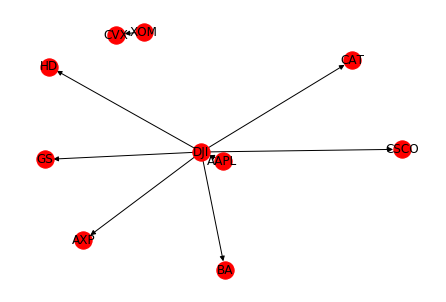

In [103]:
cbn_opt.draw_network(names=label)

### Performing Hill Climbing Search for Optimal Structure using Drawdowns data

In [105]:
cbn_opt = SPS(D,N,p_0,copula,nbhd=1,cur = [])

{(7, 3), (6, 7), (8, 2), (4, 8), (2, 8), (7, 6), (5, 7), (8, 4), (9, 3), (3, 7), (1, 5), (7, 5), (3, 9), (0, 4), (5, 1), (4, 0)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.02520127301116
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866323703854
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72.1229837876847
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -140.39742176564323
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfull

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866323703854
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72.1229837876847
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -140.39742176564323
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -22.075536854038344
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
[(0, 4), (1, 5), (5, 7), (6, 7), (7, 3), (8, 2), (8, 4), (9, 3)]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -107.66

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -64.5659142293427
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
[(0, 4), (4, 8), (5, 7), (5, 1), (6, 7), (7, 3), (8, 2), (9, 3)]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.02520127301116
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72.1229837876847
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -140.39742176564323
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866323703854
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.99546980096687
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -135.38681177979052
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -22.075536854038344
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -22.075536854038344
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -64.5659142293427
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
[(0, 4), (1, 5), (4, 8), (7, 3), (7, 6), (8, 2), (9, 3)]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.02520127301116
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.568663237038

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72.1229837876847
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.0252012730194
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -135.38681177979052
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -22.075536854038344
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -13.119617075579146
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
[(0, 4), (1, 5), (3, 9), (5, 7), (7, 3), (7, 6), (8, 2), (8, 4)]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -107.66370025736248
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866323703854
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.05

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866323703854
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.056518884400218
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72.1229837876847
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -13.119617075579146
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.0252012730194
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -135.38681177979052
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -13.119617075579146
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -64.5659142293427
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -13.119617075579146
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
[(1, 5), (3, 9), (4, 0), (5, 7), (7, 3), (7, 6), (8, 2), (8, 4)]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866323703854
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.056518884400218
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.02

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -76.56866323703854
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.056518884400218
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72.1229837876847
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -88.0252012730194
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -13.119617075579146
            Iterations: 4
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.056518884400218
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72.1229837876847
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -135.38681177979052
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -13.119617075579146
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68.77864176308779
            Iterations: 5
            Function evalu

In [106]:
#Optimal local copula and their parameters
cbn_opt.G,cbn_opt.param_c

([[5, 1], [9, 3], [8, 4], [0, 4], [7, 5], [3, 7], [6, 7], [2, 8]],
 array([1.8176733 , 0.57225231, 1.39262035, 1.94659765, 2.61913241,
        0.48719662, 1.50572487, 1.64042108]))

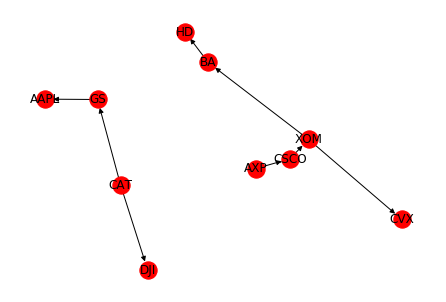

In [114]:
nx.drawing.layout.spectral_layout(cbn_opt.graph)
cbn_opt.draw_network(names=label)

In [ ]:
np.save('dd_10_graph.npy',cbn_opt.G)
np.save('dd_10_params.npy',cbn_opt.param_c)